# New Contributor & Conversion Rate Analysis Test

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json

from datetime import datetime

warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
pd.set_option('display.max_rows', 100)

## Repo Filter

In [3]:
#declare all repo ids you would like to produce charts for
repo_set = {1} #CHAOSS  25445, 25450

# #can be set as 'competitors' or 'repo'
# #'competitors' will group graphs by type, so it is easy to compare across repos
# # 'repo' will group graphs by repo so it is easy to look at all the contributor data for each repo
# display_grouping = 'repo'

# #if display_grouping is set to 'competitors', enter the repo ids you do no want to alias, if 'display_grouping' is set to repo the list will not effect anything
# not_aliased_repos = [25440, 25448]

#group_by can be set as 'month' or 'year'
group_by = 'month'

#requirements for a contributor to be considered a repeat contributor
time = 365
num_contributions_required = 3

#specify dates for filtering
#if the end_date is in the future, the end_date will default to the current_date
begin_date = '1970-10-01'
end_date = '2019-10-01'

"""
new: assess_date - the date you will use to assess whether the person has become a repeat contributor.
used similar to time (above) however it is a date and parametrizes the date at which you assess the conversion rate.

If not specified, or in future, the date will default to today's date. 
"""
assess_date = str(datetime.now().date())

save_files = False

if not begin_date:
    begin_date = '1970-1-1 00:00:01'
if not end_date:
    end_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
if not assess_date:
    assess_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [4]:
#create tuple that contains all the contributor rankings needed
rank_list = []
for num in range(1, num_contributions_required + 1):
    rank_list.append(num)
rank_tuple = tuple(rank_list)

## Query New Contributors (in terms of merged pull requests)

Loosely based on code in new_contributor Jupyter notebook.

In [5]:
df_new_contributors_mpr = pd.DataFrame()

for repo_id in repo_set: 

#     Query to find if first pull request ever merged is within a particular period (inclusive).
#         (aka, if they were "NEW" during said period)
#     Also, how many PRs they got merged DURING that time period. PRs outside time period will not be included in the count.
#     If yes, then the name will appear in this list. If the person was "NEW" before or after the period, then they cannot be included.
#     A contributor can be considered for newness as long as they get at least 1 PR merged. 
    new_contributors_query = salc.sql.text(f"""     
        SELECT pr_augur_contributor_id, first_pr_date, count, cntrb_id, cntrb_login
        FROM
            (SELECT pr.pr_augur_contributor_id, MIN(pr.pr_merged_at) AS first_pr_date, COUNT(pr.pr_augur_contributor_id)
            FROM pull_requests as pr
            WHERE pr.pr_merged_at is NOT NULL
                AND pr.pr_merged_at::date BETWEEN '{begin_date}'::date AND '{end_date}'::date
            GROUP BY pr.pr_augur_contributor_id
            ORDER BY pr.pr_augur_contributor_id) AS first_pr_times
        INNER JOIN contributors
        ON first_pr_times.pr_augur_contributor_id = contributors.cntrb_id
        ORDER BY count DESC
    """)


    df_first_repo = pd.read_sql(new_contributors_query, con=engine)
    if not df_new_contributors_mpr.empty: 
        df_new_contributors_mpr = pd.concat([df_new_contributors_mpr, df_first_repo]) 
    else: 
        # first repo
        df_new_contributors_mpr = df_first_repo


print(df_new_contributors_mpr.shape[0])


33


In [6]:
# display(df_new_contributors_mpr)

## Query New Contributors (in terms of merged pull requests) becoming repeat/sustained

As mentioned before, this query will answer how many people who were new in [begin_date, end_date] have since become repeat/sustained during the period [begin_date, assess_date]?

This will yield a percent for a rudimentary conversion rate, as in the only data used for the calculation are the merged pull requests in the specified periods.

We can assess this with an inner join, then comparing with the results from the above df.

This does not YET filter out bots. Nor does it differentiate between sustained and repeated.

In [7]:
def compute_df_repeated_mpr(repo_set, assess_date):
    df_repeated_mpr = pd.DataFrame()
    for repo_id in repo_set: 
        repeated_contributors_from_new = salc.sql.text(f"""    
            SELECT * 
            FROM
                (SELECT pr_augur_contributor_id, first_pr_date, count, cntrb_id, cntrb_login
                FROM
                    (SELECT pr.pr_augur_contributor_id, MIN(pr.pr_merged_at) AS first_pr_date, COUNT(pr.pr_augur_contributor_id)
                    FROM pull_requests as pr
                    WHERE pr.pr_merged_at is NOT NULL
                        AND pr.pr_merged_at::date BETWEEN '{begin_date}'::date AND '{end_date}'::date
                    GROUP BY pr.pr_augur_contributor_id
                    ORDER BY pr.pr_augur_contributor_id) AS first_pr_times
                INNER JOIN contributors
                ON first_pr_times.pr_augur_contributor_id = contributors.cntrb_id
                ORDER BY count DESC) as new_contributors

                INNER JOIN

                (SELECT pr_augur_contributor_id, count, cntrb_id, cntrb_login
                FROM
                    (SELECT pr.pr_augur_contributor_id, COUNT(pr.pr_augur_contributor_id)
                    FROM pull_requests as pr
                    WHERE pr.pr_merged_at is NOT NULL
                        AND pr.pr_merged_at::date BETWEEN '{begin_date}'::date AND '{assess_date}'::date
                    GROUP BY pr.pr_augur_contributor_id
                    ORDER BY pr.pr_augur_contributor_id) AS num_merged_prs_in_interval
                INNER JOIN contributors
                ON num_merged_prs_in_interval.pr_augur_contributor_id = contributors.cntrb_id
                WHERE count > {num_contributions_required}
                ORDER BY count DESC) as all_repeat_contributors

                ON new_contributors.pr_augur_contributor_id = all_repeat_contributors.pr_augur_contributor_id
        """)



        df_first_repo = pd.read_sql(repeated_contributors_from_new, con=engine)
        if not df_repeated_mpr.empty: 
            df_repeated_mpr = pd.concat([df_repeated_mpr, df_first_repo]) 
        else: 
            # first repo
            df_repeated_mpr = df_first_repo
    return df_repeated_mpr


print(assess_date)
df_repeated_mpr = compute_df_repeated_mpr(repo_set, assess_date)

df_repeated_mpr.shape[0]

2022-04-06


14

In [8]:
# df_repeated_mpr

## Final Percent: repeat Contributors / new Contributors (in terms of merged pull requests)

In [9]:
def conversion_rate_mpr(df_new_contributors_mpr, df_repeated_mpr):
    num_new_contributors = df_new_contributors_mpr.shape[0]
    num_repeated_contributors = df_repeated_mpr.shape[0]
    return (num_repeated_contributors/num_new_contributors)*100

print(f"Conversion Rate (data from merged pull requests only) assessed at {assess_date} of new contributors \
who had their first MPR during [{begin_date}, {end_date}] = {conversion_rate_mpr(df_new_contributors_mpr, df_repeated_mpr)}%")

Conversion Rate (data from merged pull requests only) assessed at 2022-04-06 of new contributors who had their first MPR during [1970-10-01, 2019-10-01] = 42.42424242424242%


## Visualization of conversion rate (in terms of merged pull requests only) over time [granularity = month] starting from end_date to now.

"months"are calculated by time elapsed (30.436875 days avg/2629746 seconds), not necessarily in terms of when months start and end on a calendar, to make intervals between measurements consistent. Timezone is assumed UTC for now.

In [10]:
# First, calculate how many full months since the end_date (inclusive)
end_date_unix_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
assess_date_unix_ts = int(datetime.strptime(assess_date, '%Y-%m-%d').timestamp())
one_month_in_seconds = 2629746
datapoint_dates = list(range(end_date_unix_ts, assess_date_unix_ts+1, 2629746))
num_repeated_contributors_at_datapoints = []

for timestamp in datapoint_dates:
    num_repeated_contributors_at_datapoints.append(compute_df_repeated_mpr(repo_set, datetime.fromtimestamp(timestamp).date()).shape[0])

conversion_rates = [(i/df_new_contributors_mpr.shape[0])*100 for i in num_repeated_contributors_at_datapoints]
print(f"conversion_rates = {conversion_rates}")

conversion_rates = [33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 33.33333333333333, 36.36363636363637, 36.36363636363637, 36.36363636363637, 36.36363636363637, 36.36363636363637, 39.39393939393939, 39.39393939393939, 39.39393939393939, 39.39393939393939, 39.39393939393939, 39.39393939393939, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242, 42.42424242424242]


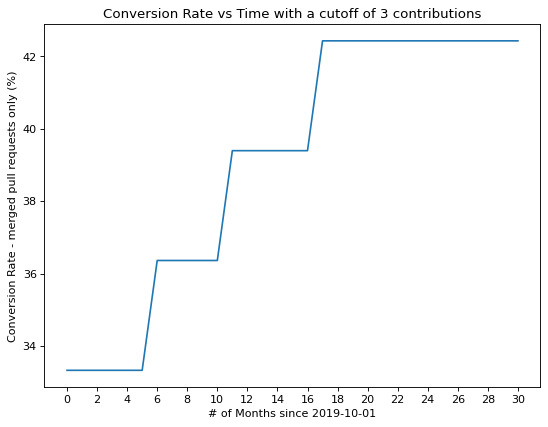

In [21]:
# plt.bar(list(df.index), df['count'])
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel(f"# of Months since {end_date}")
plt.ylabel("Conversion Rate - merged pull requests only (%)")
plt.title(f"Conversion Rate vs Time with a cutoff of {num_contributions_required} contributions")
plt.plot(range(len(datapoint_dates)), conversion_rates)
plt.xticks(np.arange(0, len(datapoint_dates), 2.0))
plt.show()

# New Contributor & Conversion Rate Analysis Test - With OpenSearch


source $HOME/.virtualenvs/comm_reports_env/bin/activate

See OpenSearch Documentation for tutorial which this notebook is based on.

Objective:
- Test Opensearch connector for loading data from pandas dataframe

In [22]:
from opensearchpy import OpenSearch

In [23]:
host = 'localhost'
port = 9200
auth = ('admin', 'admin') # For testing only. 

In [48]:
# Create the client with SSL/TLS enabled, but hostname verification disabled.
client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = auth,
    use_ssl = True,
    verify_certs = False,
#     ssl_assert_hostname = False,
#     ssl_show_warn = False,
)

In [49]:
client

<OpenSearch([{'host': 'localhost', 'port': 9200}])>

In [50]:
# Create an index with non-default settings.
index_name = 'cr-test-index'
index_body = {
  'settings': {
    'index': {
      'number_of_shards': 4
    }
  }
}

In [51]:
response = client.indices.create(index_name, body=index_body)
print('\nCreating index:')
print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'cr-test-index'}


In [52]:
conversion_rates

[33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 36.36363636363637,
 36.36363636363637,
 36.36363636363637,
 36.36363636363637,
 36.36363636363637,
 39.39393939393939,
 39.39393939393939,
 39.39393939393939,
 39.39393939393939,
 39.39393939393939,
 39.39393939393939,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242,
 42.42424242424242]

In [57]:
for i in range(len(conversion_rates)):
    # Add a document to the index.
    document = {
      'date': datapoint_dates[i],
      'rate': conversion_rates[i],
    }
    id = i

    response = client.index(
        index = index_name,
        body = document,
        id = i,
        refresh = True
    )

    print('\nAdding document:')
    print(response)


Adding document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '0', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1}

Adding document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '1', '_version': 33, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 32, '_primary_term': 1}

Adding document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '2', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 33, '_primary_term': 1}

Adding document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '3', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 34, '_primary_term': 1}

Adding document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '4', '_version': 1, 'result': 

In [58]:
client.search(index="cr-test-index", doc_type="_doc", body = {
'size' : 100,
'query': {
    'match_all' : {}
}
})

{'took': 27,
 'timed_out': False,
 '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 31, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'cr-test-index',
    '_type': '_doc',
    '_id': '1',
    '_score': 1.0,
    '_source': {'date': 1572542946, 'rate': 33.33333333333333}},
   {'_index': 'cr-test-index',
    '_type': '_doc',
    '_id': '3',
    '_score': 1.0,
    '_source': {'date': 1577802438, 'rate': 33.33333333333333}},
   {'_index': 'cr-test-index',
    '_type': '_doc',
    '_id': '6',
    '_score': 1.0,
    '_source': {'date': 1585691676, 'rate': 36.36363636363637}},
   {'_index': 'cr-test-index',
    '_type': '_doc',
    '_id': '9',
    '_score': 1.0,
    '_source': {'date': 1593580914, 'rate': 36.36363636363637}},
   {'_index': 'cr-test-index',
    '_type': '_doc',
    '_id': '10',
    '_score': 1.0,
    '_source': {'date': 1596210660, 'rate': 36.36363636363637}},
   {'_index': 'cr-test-index',
    '_type': '_doc',
   

In [ ]:
# Search for the document.
q = 'query_here'
query = {
  'size': 5,
  'query': {
    'multi_match': {
      'query': q,
      'fields': ['title^2', 'director']
    }
  }
}

response = client.search(
    body = query,
    index = index_name
)
print('\nSearch results:')
print(response)

In [56]:
# Delete the document.
response = client.delete(
    index = index_name,
    id = '1'
)

print('\nDeleting document:')
print(response)


Deleting document:
{'_index': 'cr-test-index', '_type': '_doc', '_id': '1', '_version': 32, 'result': 'deleted', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 31, '_primary_term': 1}


In [ ]:
# Delete the index.
response = client.indices.delete(
    index = index_name
)

print('\nDeleting index:')
print(response)